Text(0, 0.5, 'Cycle life')

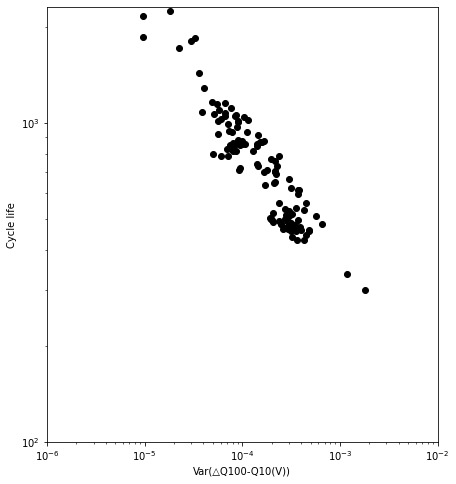

In [56]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

X=[]
Y=[]

for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),bat_dict[j]['cycle_life'].tolist()
    X.append(var)
    Y.append(cycle[0][0])
    
plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')

# 이 회귀분석에 대한 이론이 나오기 전에 논문에서 제공한 LFP데이터 분석이 먼저 나와야 한다.
논문에서 가장 많이 언급되었던 (Var(Q(100-10)) , Cycle life) 데이터를 통해서 머신러닝 이론에 대해서 살펴본다(이때 그래프는 x,y축을 log scale로 설정).

# 1. 정규방정식 Ordinary least squares

(코드화) 

\begin{equation}\label{eqn:linear}
    y_i={w_1}{x_{i,1}}+{w_2}{x_{i,2}}...+{w_p}{x_{i,p}}+b_i={x_{i}^T}{\textbf{W}}+b_i\qquad i=1,2,...,n
\end{equation}

$y_i$는 예측값, p는 특성의 수, $x_{n,p}$는 p번째 특성 값, $w_i$는 i번째 파리미터를 나타내며 행렬로 나타내면:

\begin{equation}
    y=\textbf{XW}
\end{equation}

\begin{equation}
    y=
    \begin{bmatrix}
        y_1\\
        \vdots\\
        y_n
    \end{bmatrix}
    \qquad \textbf{X}=
    \begin{bmatrix}
        x_{1}^T\\
        \vdots\\
        x_{n}^T
    \end{bmatrix}
    =
    \begin{bmatrix}
        x_{11} &  \cdots & x_{1p}\\
        \vdots & \ddots & \vdots\\
        x_{n1} &  \cdots & x_{np}
    \end{bmatrix}
    \qquad x_{i}=
    \begin{bmatrix}
        x_{i1}\\
        \vdots\\
        x_{ip}
    \end{bmatrix}  
    \qquad \textbf{W}=
    \begin{bmatrix}
        w_1\\
        \vdots\\
        w_p
    \end{bmatrix}
\end{equation}

선형회귀 모델을 훈련하여 잘 맞는 파라미터를 찾고 성능을 측정한다. 이 때 사용하는 성능측정지표는 RMSE(Root Mean Square Error) 이며 , 이 값이 최소가 되는 값을 찾아야 한다. 이는 MSE(Mean Square Error)를 최소화하는것과 같다. 이 MSE를 Cost function. Loss function 이라고 부르며, 이 값이 최소값이 되도록 하는 것을 최소제곱법(method of least squares)이라 부른다. MSE 값이 최소가 되기 위한 방법은 1. 미분값이 0이 되는 지점을 찾는다. 2. 경사하강법 이 있다. 이를 Optimization 이라고 한다.[밑바닥부터 시작하는 딥러닉 책] 경사하강법 에대한 단점을 개선해주는 Momentum, AdaFrad, Adam 최적화(Optimization) 이 있다.

\begin{equation}
    MSE=\frac{1}{n}\sum_{i=1}^{n}{(\textbf{W}^{T}\cdot{x_i}-{y_i})^2}
\end{equation}

\begin{align}
    MSE &=(\textbf{W}^T\cdot\textbf{X}^T-{y^T})(\textbf{W}^T\cdot\textbf{X}^T-{y^T})^T\\ &= (\textbf{W}^T\cdot\textbf{X}^T-{y^T})(\textbf{X}\cdot\textbf{W}-{y})\\ &=\textbf{W}^T\cdot\textbf{X}^T\cdot\textbf{X}\cdot\textbf{W}-2\textbf{W}^T\cdot\textbf{X}^T\cdot{y}+{y}^T\cdot{y}
\end{align}


\begin{equation}
    \frac{\partial{MSE(\textbf{W})}}{\partial{\textbf{W}}}=({\textbf{X}^T}\cdot{\textbf{X}}+{\textbf{X}}\cdot{\textbf{X}^T})\cdot{\textbf{W}}-2{\textbf{X}^T}\cdot{y}=0
\end{equation}

$$
\hat{\mathbf{W}} = \left( \mathbf{X}^{T} \cdot \mathbf{X} \right)^{-1} \cdot \mathbf{X}^{T} \cdot \mathbf{y}
$$

y는 $n\times1$ , $\textbf{X}$는 $n\times p$ , $\textbf{W}$는 $p\times 1$, $x_i$는 $p\times 1$ 행렬로 나타낼 수 있으며 $x_{i1},i=1,...,n$은 bias 값에 해당한다.

[[ 2.9930046 ]
 [-0.40742467]]


Text(0.5, 1.0, 'Normal Equation')

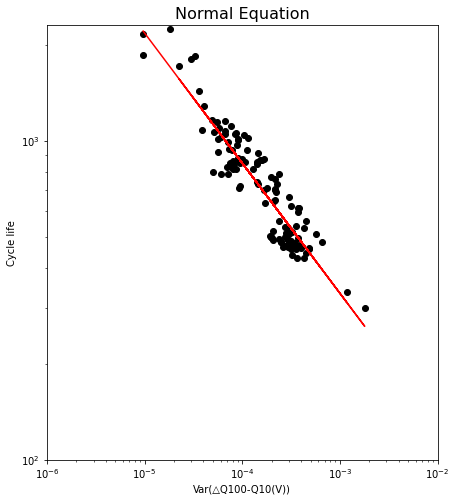

In [57]:
m= len(X)
X= np.array(X).reshape(-1,1)
X_b = np.c_[np.ones((m,1)), np.log(X)] # 두 배열을 세로로 붙여서 2차원 배열 만들기
Y= np.array(Y).reshape(-1,1)

theta_best=np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(np.log(Y))
print(theta_best)

y_predict = X_b.dot(theta_best)


plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.plot(X,np.exp(y_predict),c='red')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')
plt.title('Normal Equation',fontsize=16)

# 2. SVD(Singular Value Decomposition)
Scikit-Learn의 LinearRegression 은 SVD(Singular Value Decomposition)를 사용함.
정규 방정식은 계산복잡도가 $O(n^{2.4})$에서 $O(n^3)$사이로 feature수가 2배 늘어날 수록 계산시간이 $2^{2.4}=5.3$에서 $2^3=8$배 증가하여 매우 느려진다. 그래서 계산복잡도가 $O(n^2)$인 SVD 를 사용한다.SVD는 특성 수가 2배로 증가하면 계산 시간은 4배로 증가한다. SVD(Singular Value Decomposition)는 특잇값 분해로 표준 행렬 분해 기법을 사용해서 $\hat{\textbf{W}}=\textbf{X}^{+}\cdot{y}$ 를 계산 한다. $\textbf{X}^{+}$는 Pseudoinverse이며 코드로는 np.linalg.pinv()로 계산된다. Pseudoinverse은 $\textbf{X}^{+}=\textbf{V}\cdot\textbf{$\Sigma^{+}$}\cdot\textbf{U}^{T}$로 계산된다. 
$\textbf{U}$ 는 $m\times{m}$ 직각행렬 , $\textbf{V}$ 는 $n\times{n}$ 직각행렬, $\textbf{$\Sigma$}$ 는 $m\times{n}$ 대각행렬이다. 

[[-0.40742467]] [2.9930046] LinearRegression()


Text(0.5, 1.0, 'SVD_LinearRegression')

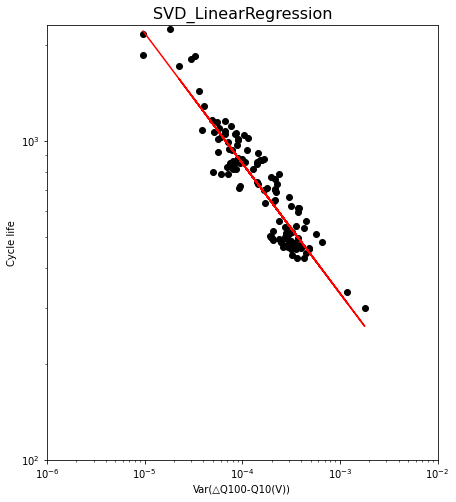

In [4]:
#LinearRegression
from sklearn.linear_model import LinearRegression
line_reg= LinearRegression()
line_reg.fit(np.log(X),np.log(Y))
print(line_reg.coef_ , line_reg.intercept_,line_reg )

y=line_reg.coef_*np.log(X)+line_reg.intercept_

plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.plot(X,np.exp(y),c='red')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')
plt.title('SVD_LinearRegression',fontsize=16)

# 3. 경사하강법 
(최적화 방법)
$$
\nabla_{\mathbf{W}} \text{MSE}(\mathbf{W}) = \begin{bmatrix} \frac { \partial  }{ \partial w_{ i } } { MSE }(W) \\ \vdots \\ \frac { \partial  }{ \partial w_{ i } } { MSE }(W) \end{bmatrix} = \frac{2}{m} \mathbf{X}^{T} \cdot \left( \mathbf{X} \cdot \mathbf{W} - \mathbf{y} \right)
$$

경사 하강법 Step
$$
\mathrm{W}^{(next step)} = \mathrm{W} - \eta \nabla_{\mathbf{W}} \text{MSE}(\mathbf{W})
$$
$$
 \mathrm{W} \leftarrow \mathrm{W} - \eta \frac{\partial L}{\partial \mathrm{W}} 
$$

경사하강법은 파라미터 벡터(가중치)에 대해서 비용함수의 현재 기울기를 계산하게 하고 기울기가 감소하는 방향으로 진행한다. 구체적으로 코드를 보면 임의의 값으로 가중치를 주어지고(무작위 초기화, random initialization)학습률(Learning Rate)를 기울기와 곱해서 이전 가중치에서 빼준다. 이때 학습률과 epochs 수를 하이퍼파라미터로 설정한다, 그리고 학습률이 너무 작을 경우에는 알고리즘이 수렴하기 전에 반복이 끝나서 최소값을 못찾을 수 있다. 만일 학습률이 너무 클 경우 알고리즘이 더 큰 값으로 발산하게 된다. 
또 cost function은 지역 최소값, 전역 최소값이 존재 할 수 있다. ( MSE는 볼록함수(Convex Function)이라서 지역최소값은 없고 전역 최소값만 있다.) 

모멘텀 step

모멘텀, Adam 옵티마이저는 딥러닝에서 표준 경사하강법 옵티마이저 대신 더 빠른 옵티마이저를 사용할때 사용하는 고속 옵티마이저 방법이다.
$$
\mathrm{v} \leftarrow \mathrm{{\alpha}{\mathrm{v}}} - \eta \frac{\partial{L}}{\partial{\textbf{W}}}
$$
$$\mathrm{W} \leftarrow \mathrm{W} + \mathrm{v}$$
위에서 언급했던 모멘텀의 경우는 $\mathbf{v}$ 변수가 새롭게 나타나며 이는 물리에서 속도(Velocity)다. 또한 모멘텀이라는 새로운 하이퍼파라미터 $\alpha$을 통해서 마찰저항을 표현했으며 물체가 서서히 하강하는 것을 구현하였다(0(높은마찰저항)~1(낮은마찰저항) 사이로 설정되며, 이란적인 모멘텀 값은 0.9다.).매 반복에서 현재 기울기를 모멘텀 벡터 \mathrm{v}에 더하고 이 값을 빼는 방식으로 가중치를 갱신한다. 즉, 기울기를 속도가 아니라 가속도로 사용한다. 이 방법은 지역 최적점을 건너뛰는데 도움이 된다.
$\frac{\partial{L}}{\partial{\textbf{W}}}$ = 손실함수 , $\eta$= 학습률


AdaGrad ( RMSProp) step

 AdaGrad 옵티마이저는 심층 신경망에서는 사용하면 안된다. (선형회귀에서는 효과적일 수 있다.

Adam step

# 배치 경사 하강법
배치 경사 하강법은 전체 훈련세트 $\mathbf{X}$ 에 대해서 계산하는것이다. 매 스텝에서 전체 데이터를 사용하는 것이다. 때문에 이 training은 매우 큰 샘플 데이터에서 느린 결과를 가져온다. (그러나 특성 수가 많을 때 경사하강법은 특성 수에는 상관 없어서 정규방적식이나 SVD 보다 빠른 결과를 가져온다.)

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in subtract
  # This is added back by InteractiveShellApp.init_path()


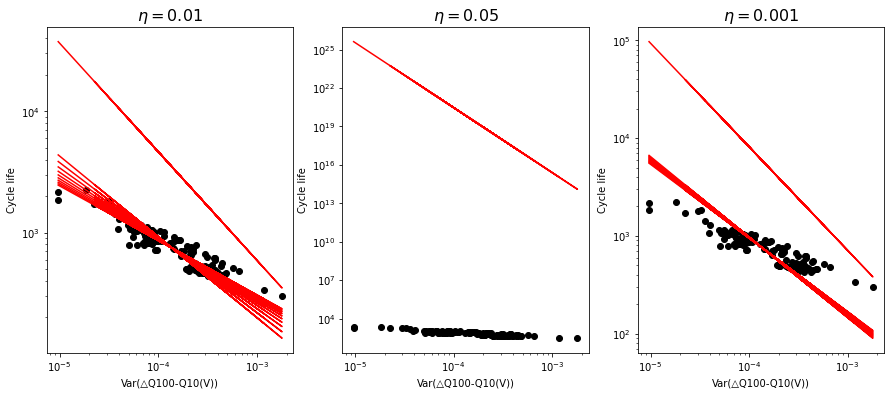

In [5]:
plt.figure(figsize=(15,6))
lr = 0.01
epochs = 10001


def make_plot(lr,epochs):
    theta=  np.random.randn(2,1)
    plt.scatter(X,Y,color='black')
    for i in range(epochs):
        gradient = 2/m *X_b.T.dot(X_b.dot(theta)-np.log(Y))
        theta = theta - lr*gradient
        if i % 1000 == 0: 
            #print('{}:'.format(lr),theta)
            y=X_b.dot(theta)
            plt.plot(X,np.exp(y),c='red')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Var(△Q100-Q10(V))')
            plt.ylabel('Cycle life')
            plt.title(r"$\eta = {}$".format(lr), fontsize=16)
            
plt.subplot(131); make_plot(lr = 0.01,epochs = 10001)
plt.subplot(132); make_plot(lr = 0.05,epochs = 10001)
plt.subplot(133); make_plot(lr = 0.001,epochs = 10001)
plt.show()

standardScaler => 데이터의 각 특성에서 평균을 빼고 표준편차로 나누어 평균을 0 , 분산을 1 로 만든다.
훈련데이터와 테스트데이터를 나눴을 때 훈련데이터에 대해서 표준화를 fit 한 후에 다시 훈련데이터와 테스트데이터를 transform 해줘야 한다. 머신러닝 과정에서 절대로 테스트 데이터에서 계산한 값을 사용하면 안된다, 이는 각각을 다른 스케일로 변환하게 되는것이 되기 때문이다. 즉, 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 한다.

 위 그래프는 표준화를 진행하지 않은 것으로 epochs 수가 매우 높음을 볼 수 있다(10000, 1000번째 epoch 마다 그래프를 그림.).

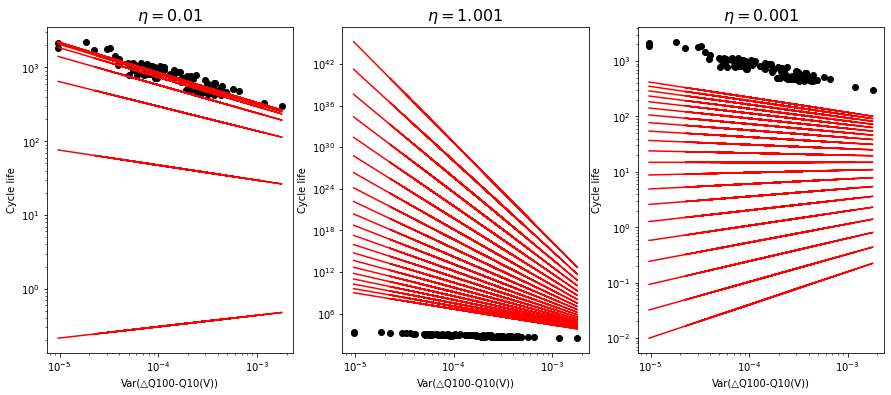

In [6]:
from sklearn.preprocessing import StandardScaler
plt.figure(figsize=(15,6))
scaler = StandardScaler() 
#X_scaled = scaler.fit(X_train).transform(X_train) 즉, train 데이터로 fit 해주고 훈련데이터와 검증데이터를 transform 해준다.
#X_test_scaled = scaler.transform(X_test)
X_scaler = scaler.fit_transform(np.log(X))
X_b_scaler = np.c_[np.ones((m,1)), X_scaler]

weight_path_bgd = []
def make_plot(lr,epochs,weight_path=None):
    theta=  np.random.randn(2,1)
    plt.scatter(X,Y,color='black')
    for i in range(epochs):
        gradient = 2/m *X_b_scaler.T.dot(X_b_scaler.dot(theta)-np.log(Y))
        theta = theta - lr*gradient
        if weight_path is not None:
            weight_path.append(theta)
        if i % 50 == 0: 
            #print('{}:'.format(lr),theta)
            y=X_b_scaler.dot(theta)
            plt.plot(X,np.exp(y),c='red')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Var(△Q100-Q10(V))')
            plt.ylabel('Cycle life')
            plt.title(r"$\eta = {}$".format(lr), fontsize=16)
            
plt.subplot(131); make_plot(lr = 0.01,epochs = 1001,weight_path=weight_path_bgd)
plt.subplot(132); make_plot(lr = 1.001,epochs = 1001)
plt.subplot(133); make_plot(lr = 0.001,epochs = 1001)
plt.show()

표준화를 진행한 위 그래프를 보게 되면 epochs 값이 1000이며 50번째 epoch마다 그래프를 그렸다. 표준화를 진행하기 전보다 더 빠르게 값이 수렴함을 볼 수 있다.  또한 학습률을 보게 되면 적당한 학습률을 갖는 알고리즘은 빠르게 수렴하는 모습을 볼 수 있다. 그러나 너무 작은 학습률을 갖는 것은 알고리즘이 수렴하기 위해서 더 많은 epochs 가 필요하며, 너무 큰 학습률은 알고리즘이 발산하는 모습을 볼 수 있다. 

# 확률적 경사 하강법(Stochastic Gradient Descent )
위의 배치 경사 하강법은 전체 데이터를 사용해서 계산을 하기 때문에 훈련데이터가 커지게 되면 학습이 매우 느려지게 되므로 이를 해결하기 위해서 매 스텝에서 랜덤하게 하나의 데이터를 선택해서 경사하강법을 진행하는 것이다. 이는 속도는 매우 빠르지만 Cost function이 불규칙하게 감소하게 된다. 이는 지역 최소값을 건너뛸 수 있는 가능성이 있지만 전역 최소값에 다다르지 못하는 경우가 있어서 이를 해결하기 위해서 learning rate decay 기법을 사용한다. learning rate decay 기법은 학습을 시작할 때 학습률을 크게 하고 점진적으로 학습률을 줄여 전역최소값에 도달하도록 만든다.

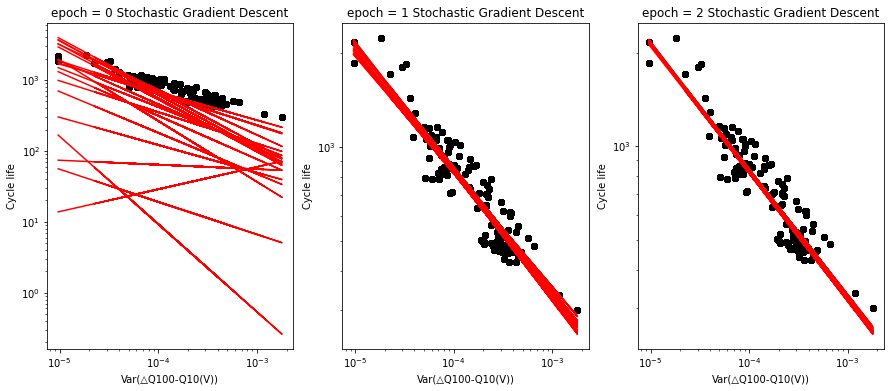

In [7]:
plt.figure(figsize=(15,6))
weight_path_sgd = []
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

def SGD(x,weight_path=None):
    theta=  np.random.randn(2,1)
    for epoch in range(n_epochs):
        for i in range(m):
            random_index = np.random.randint(m)
            xi = X_b_scaler[random_index:random_index+1]
            yi = np.log(Y)[random_index:random_index+1]
            gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
            eta = learning_schedule(epoch * m + i)
            theta = theta - eta * gradients
            if weight_path is not None:
                weight_path_sgd.append(theta)        
            if epoch == x and i <20 : 
                y=X_b_scaler.dot(theta)
                plt.plot(X,np.exp(y),c='red')
                plt.xscale('log')
                plt.yscale('log')
                plt.xlabel('Var(△Q100-Q10(V))')
                plt.ylabel('Cycle life')
                plt.title('epoch = {} Stochastic Gradient Descent'.format(epoch), fontsize=12)
                plt.scatter(X,Y,color='black')
plt.subplot(131); SGD(x=0, weight_path=weight_path_sgd)
plt.subplot(132); SGD(x=1)
plt.subplot(133); SGD(x=2)
plt.show()

 Stochastic Gradient Descent 그래프는 epochs 50 개로 진행. 이 방법은 Scikit-Learn에서는 SGD방법을 이용한 Regression인 SGDRegressor 클래스로 사용 할 수 있다.

In [8]:
print(weight_path_sgd[-1])

[[ 6.58059892]
 [-0.36453207]]


위 결과는 50번의 epochs를 진행했을때 얻어지는 결과
# SGDRegressor

In [9]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X_scaler, np.log(Y).ravel())

SGDRegressor(eta0=0.1, max_iter=50, penalty=None, random_state=42)

In [10]:
print(sgd_reg.intercept_, sgd_reg.coef_)

[6.5841237] [-0.36687533]


위 결과는 SGDRegressor를 이용해서 50 epochs를 진행했을 때의 결과 이때 학습률은 0.1 로 설정을 했다 . 이는
$\eta^{t}=\frac{eta0}{t^{power_t}}$ 로 설정이 되어있다. (직접 만든 코드와는 다른 공식) 때문에 결과는 비슷하지만 같게 나타나지 않았다.


# 미니배치 경사 하강법(Mini-Batch Gradient Descent)

미니배치 경사 하강법(Mini-batch Gradient Descent)은 각 스텝에서 전체 Train Set을 미니배치(mini-batch),
즉 작은 데이터셋을 추출한 뒤 Gradient를 계산하는 방법
미니배치 경사 하강법은 SGD에 비해 덜 불규칙하게 감소하지만, local minimum에 빠질 확률은 높다.
미니 배치 경사는 에포크마다 훈련데이터를 섞고 미니배치 수만큼 데이터를 선택 후 다음에포크에서 다시 섞는 방법을 사용한다.

In [11]:
weight_path_mgd = []

n_iterations = 100
minibatch_size = 20
theta = np.random.randn(2,1)  # random init

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b_scaler[shuffled_indices]
    y_shuffled = np.log(Y)[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        weight_path_mgd.append(theta)
        
    if (epoch+1) % 10 == 0:
        print('Epoch :{:03d}, weight = \n {}'.format(epoch+1, theta))

Epoch :010, weight = 
 [[ 6.59501866]
 [-0.36777736]]
Epoch :020, weight = 
 [[ 6.5791171]
 [-0.3560576]]
Epoch :030, weight = 
 [[ 6.57547365]
 [-0.36278624]]
Epoch :040, weight = 
 [[ 6.59021304]
 [-0.37683433]]
Epoch :050, weight = 
 [[ 6.58151805]
 [-0.36597106]]
Epoch :060, weight = 
 [[ 6.56468603]
 [-0.36565676]]
Epoch :070, weight = 
 [[ 6.58028552]
 [-0.36790484]]
Epoch :080, weight = 
 [[ 6.58506112]
 [-0.34996367]]
Epoch :090, weight = 
 [[ 6.58319144]
 [-0.35315311]]
Epoch :100, weight = 
 [[ 6.5839221 ]
 [-0.37121702]]


In [12]:
weight_path_bgd = np.array(weight_path_bgd)
weight_path_sgd = np.array(weight_path_sgd)
weight_path_mgd = np.array(weight_path_mgd)

In [13]:
print(weight_path_bgd.shape)
print(weight_path_sgd.shape)
print(weight_path_mgd.shape)
weight_path_bgd[:,0].shape

(1001, 2, 1)
(5950, 2, 1)
(600, 2, 1)


(1001, 1)

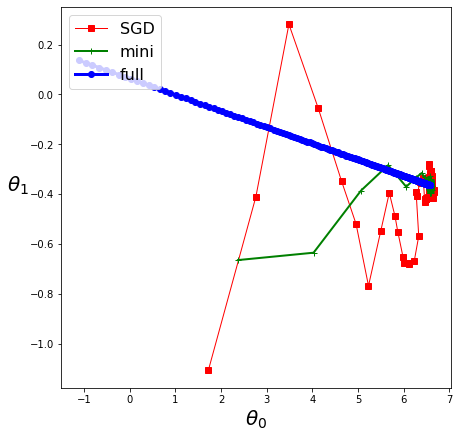

In [14]:
plt.figure(figsize=(7,7))
plt.plot(weight_path_sgd[:,0], weight_path_sgd[:,1], "r-s", linewidth=1, label="SGD")
plt.plot(weight_path_mgd[:,0], weight_path_mgd[:,1], "g-+", linewidth=2, label="mini")
plt.plot(weight_path_bgd[:,0], weight_path_bgd[:,1], "b-o", linewidth=3, label="full")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.show()

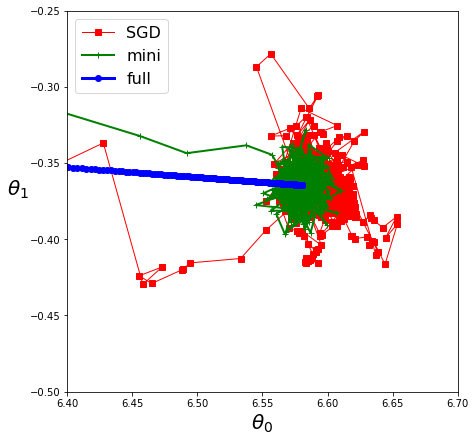

In [15]:
plt.figure(figsize=(7,7))
plt.plot(weight_path_sgd[:,0], weight_path_sgd[:,1], "r-s", linewidth=1, label="SGD")
plt.plot(weight_path_mgd[:,0], weight_path_mgd[:,1], "g-+", linewidth=2, label="mini")
plt.plot(weight_path_bgd[:,0], weight_path_bgd[:,1], "b-o", linewidth=3, label="full")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([6.4, 6.7, -0.5, -0.25])
plt.show()

# 다항회귀
다항회귀는 각 특성의 제곱을 새로운 특성을 추가하여 선형 모델을 학습시키는 방법을 말한다. 다항회귀 식:
$$
y = w_0 + w_1 x_1 + w_2 x_2^{2} + \cdots w_n x_n^{m} 
$$

Scikit-Learn의 PolynomialFeatures를 이용해서 데이터특성의 관계를 나타낼 수있다. 다음은 2차식으로 회귀를 하는 예시(degree=2)

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_scaler)
print('X[0] :', X_scaler[0])
print('X_poly[0] :', X_poly[0])

X[0] : [-3.06605961]
X_poly[0] : [-3.06605961  9.40072154]


In [17]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, np.log(Y))
print(lin_reg.intercept_, lin_reg.coef_)

[6.57034113] [[-0.36009246  0.01010271]]


$y = 0.01 x^{2} + -0.36 x + 6.57$

Text(0.5, 1.0, 'degree=2 polynomial regression')

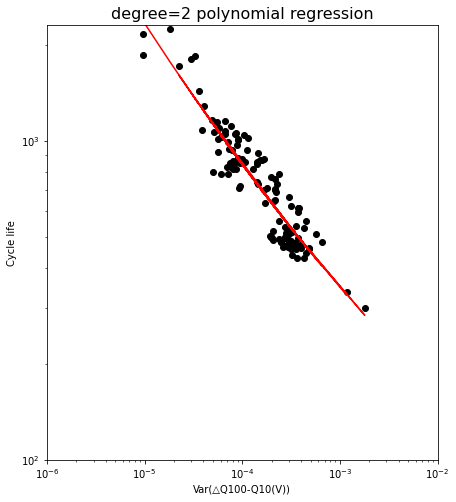

In [18]:
Y_poly=lin_reg.predict(X_poly)

plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.plot(X,np.exp(Y_poly),c='red')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')
plt.title('degree=2 polynomial regression',fontsize=16)

# 학습 곡선(Learning Curve)

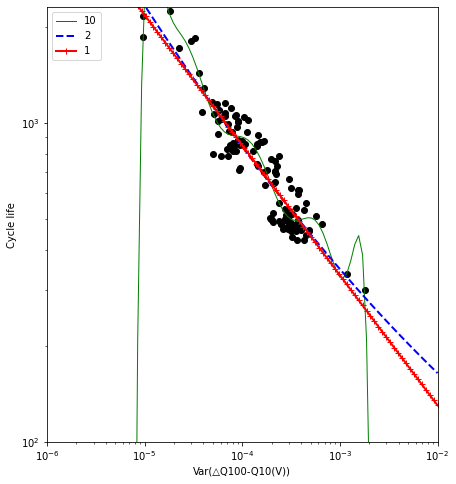

In [19]:
from sklearn.pipeline import Pipeline
plt.figure(figsize=(7,8))
scaler=StandardScaler()
X_scaler = scaler.fit_transform(np.log(X))

X_new=np.linspace(-6, -2, 100).reshape(100, 1)
X_new=np.log(np.power(10,X_new))
X_new_scaler=scaler.transform(X_new) 


for style, width, degree in (("g-", 1, 10), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("lin_reg", LinearRegression()),
        ])
    polynomial_regression.fit(X_scaler, np.log(Y))
    y_newbig = polynomial_regression.predict(X_new_scaler)
    plt.plot(np.exp(X_new), np.exp(y_newbig), style, label=str(degree), linewidth=width)

plt.scatter(X,Y,color='black')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')
plt.legend(loc="upper left")

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 모델의 학습 곡선을 그리는 함수 정의
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", label="train")
    plt.plot(np.sqrt(val_errors), "b-", label="validation")
    plt.legend(loc="upper right")   
    plt.xlabel("train set ")       
    plt.ylabel("RMSE", fontsize=14)

train set 에서 80%를 train, 20%를 validation 데이터로 만들고 train 데이터로 학습 후 validaiton 데이터로 검증했다.이때 훈련데이터의 target과 그 target을 이 모델에 적용해 예측된 데이터를 통해서 train_RMSE값을 구하고 , validation 데이터의 target과 그 target을 모델에 적용해 예측된 데이터를 통해서 Validation_RMSE 값을 구한다.

1차 Linear Regression 의 경우 검증을 하면

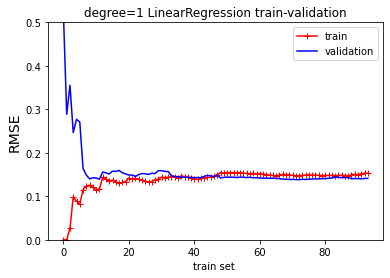

In [21]:
#1차 
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X_scaler, np.log(Y))
plt.ylim(0, 0.5)      
plt.title('degree=1 LinearRegression train-validation')
plt.show()

이 데이터 피어슨 상관계수가 0.92 정도로 1에 가까워서 1차식으로 피팅해도 과소적합의 특징이 나타나지 않아보인다.

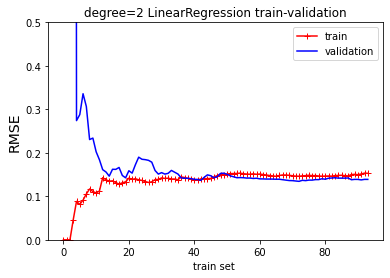

In [22]:
from sklearn.pipeline import Pipeline
#2차
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X_scaler, np.log(Y))
plt.title('degree=2 LinearRegression train-validation')
plt.ylim(0, 0.5)         
plt.show()

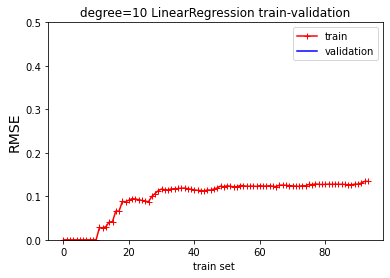

In [23]:
from sklearn.pipeline import Pipeline
#20차
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X_scaler, np.log(Y))
plt.title('degree=10 LinearRegression train-validation')
plt.ylim(0, 0.5)           
plt.show()

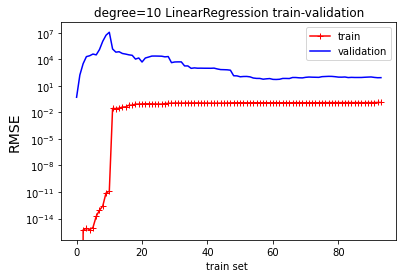

In [24]:
from sklearn.pipeline import Pipeline
#20차 
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X_scaler, np.log(Y))
plt.title('degree=10 LinearRegression train-validation')
plt.yscale('log')
#plt.ylim(0, 0.5)           
plt.show()

다항 회귀 모델은 훈련데이터의 오차가 검증데이터의 오차보다 낮은것을 볼 수 있다 이는 오버피팅 된것,

# 규제(Regularization)가 있는 선형 모델

 과대적합을 감소시키는 방법으로 모델을 규제, 제한하는것 
# L2-norm regularization (Ridge Regression)
규제(regularization)가 추가된 선형 회귀 모델, 규제항(regularization term) $\lambda \sum_{i=1}^{n}{w_{i}^{2}}$ 이 비용함수(loss function)에 추가. 모델(알고리즘)을 데이터에 적합 시키는 것뿐만 아니라 모델의 가중치가 가능한 작게 유지되도록 한다. 규제항은 학습에만 사용되며 테스트 시에는 규제항이 사용되지 않는다.

$$
\text{Ridge Regression}(w) = \text{MSE}(w) + \lambda \sum_{i=1}^{n}{w_{i}^{2}}
$$

 $\lambda$는 하이퍼파라미터이며, 모델을 얼마나 많이 규제할지 조절한다. $\lambda = 0$이면 릿지 회귀는 일반 선형 회귀와 같아지며, $\lambda$가 커지게되면 모든 가중치가 거의 0에 가까워져, 결국 데이터의 평균을 지나는 선이 된다. 이 규제는 bias는 규제되지 않는다(i=1부터 시작함을 볼 수 있다). 변수 간의 상관관계가 높은 상황에서 예측성능이 좋다. 그리고 큰 변수를 우선적으로 줄이는 경향을 보인다. [J. R. Statist. Soc. B (1996) 58, No.1, pp. 267-288]

릿지 회귀는 입력 특성의 스케일에 민감하기 때문에 데이터 스케일을 맞춰주는것이 중요하다.

Ridge Regression 의 정규방정식
$$
\hat{\mathbf{W}} = \left( \mathbf{X}^{T} \cdot \mathbf{X} + \lambda I \right)^{-1} \cdot \mathbf{X}^{T} \cdot \mathbf{y}
$$

정규방적식을 사용한 릿지 회귀 적용방법

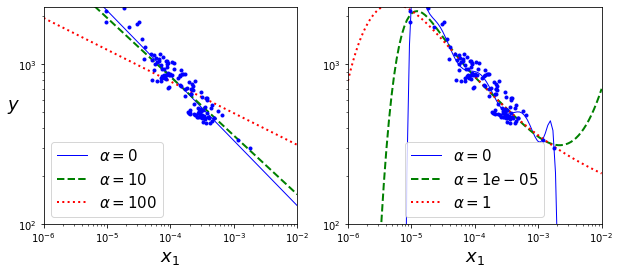

In [37]:
from sklearn.linear_model import Ridge


def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(np.log(X), np.log(Y))
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(np.exp(X_new), np.exp(y_new_regul), style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, Y, "b.", linewidth=3)
    plt.xscale('log')
    plt.yscale('log')
    plt.axis([10**(-6),10**(-2),100,2300])
    plt.legend(fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    #plt.axis([0, 3, 0, 4])

plt.figure(figsize=(10,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

In [38]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)  # alpha == lambda
ridge_reg.fit(X_scaler, np.log(Y))

Ridge(alpha=1, random_state=42, solver='cholesky')

확률적 경사 하강법을 사용한 릿지 회귀 적용방법

In [39]:
sgd_reg = SGDRegressor(max_iter=5, penalty="l2", random_state=42)
sgd_reg.fit(X_scaler, np.log(Y))

C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDRegressor(max_iter=5, random_state=42)

# L1-norm regularization (Lasso Regression)
라쏘(Lasso, Least Absolut Shrinkage and Selection Operator) 회귀  $\lambda \sum_{i=1}^{n}{\left| w_i \right|}$ 이 loss function에 추가 됨.
$$
\text{Lasso Regression}(w) = \text{MSE}(w) + \lambda \sum_{i=1}^{n}{\left| w_i \right|}
$$


Lasso is L1 – norm regularization, variable selection possible (an important variable can be selected because there is a convergence to 0 in the middle), the predictive performance is relatively poor compared to Ridge in a situation where the correlation between variables is high (the limit of Lasso) .[J. R. Statist. Soc. B (2005) 67, Part 2, pp. 301–320]

덜 중요한 특성의 가중치를 제거하려고 한다. (가중치가 0이 된다) . 즉 Lasso 는 자동으로 특성을 선택하고 sparse model을 만든다 

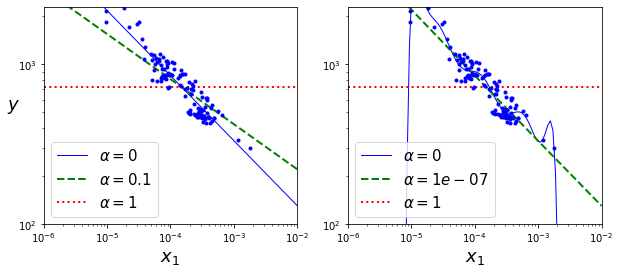

In [43]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(10,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)
plt.show()

In [40]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_scaler, np.log(Y))

Lasso(alpha=0.1)

In [41]:
sgd_reg = SGDRegressor(max_iter=5, penalty="l1", random_state=42)
sgd_reg.fit(X_scaler, np.log(Y))
sgd_reg.predict([[1.5]])

C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([4.82931507])

# Elastic Net(Ridge + Lasso (L1 and L2 regularization))

The values of L1 and L2 have a grouping effect. If it is an important variable, L1 and L2 become important together, and if it is an unimportant variable, L1 and L2 are made not to be important together. Used when selecting variables with high correlation at the same time.

$$
Elastic Net(w) = \text{MSE}(w) + \alpha \sum_{i=1}^{n}{w_i}^2 + \left( 1 - \alpha \right) \sum_{i=1}^{n}{\left| w_i \right|}, \quad \alpha = \frac{\lambda_2}{\lambda_2 + \lambda_1}
$$

규제(regularization)가 있는 모델이 대부분의 경우에 좋으므로 규제가 없는 모델을 사용하기 보다는 규제가 있는 모델을 사용하는 것이 좋다.
대부분의 경우에는 $L_2$ 규제 즉, 릿지가 좋지만 모델에 사용되는 특성이 적을것이라고 예상되는 경우에는 라쏘나, 엘라스틱넷을 사용하는 것이 좋다.
그 이유는, 라쏘나 엘라스틱넷은 불필요한 특성을 0으로 만들어 주기 때문이다.
특성 수가 Train set 보다 많거나 몇개의 특성이 강한 상관성을 보인다면 엘라스틱넷을 사용하는 것이 좋다.

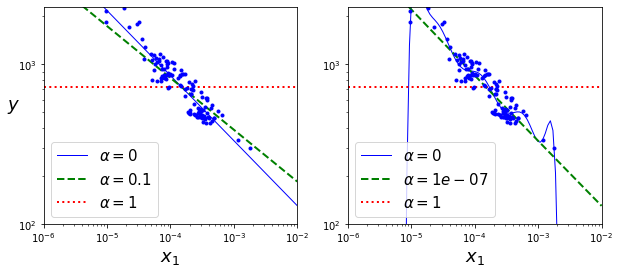

In [44]:
from sklearn.linear_model import ElasticNet
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_model(ElasticNet, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(ElasticNet, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)
plt.show()

In [42]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_scaler, np.log(Y))
elastic_net.predict([[1.5]])

array([6.13135687])

Lasso , Ridge, Elastic Net 의 예시는 ppt 8,9,10 을 보면 coefficient 값이 alpha 값에 따라 변화하는 것을 관찰 할 수 있다.

# Early Stopping
 또 다른 규제 방법으로 경사 하강법을 이용해 학습하면서 검증 세트의 error가 최소값에 도달했을 때 스텝이 남아 있더라고 학습을 중지시키는 조기종료 early stopping 이 있다.

C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Convergenc

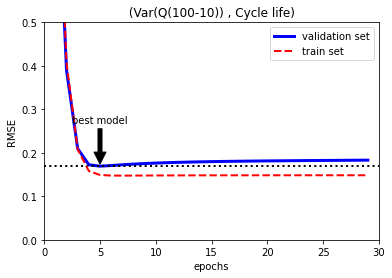

In [89]:
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])
X_train, X_val, y_train, y_val = train_test_split(np.log(X), np.log(Y), test_size=0.2, random_state=8)

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.01,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 30
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse+0.1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
plt.plot([0, n_epochs], [np.sqrt(val_errors[5]), np.sqrt(val_errors[5])], "k:", linewidth=2)
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="train set")
plt.legend(loc="upper right")
plt.axis([0,n_epochs,0,0.5])
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.title(' (Var(Q(100-10)) , Cycle life) ')
plt.show()

C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  Convergenc

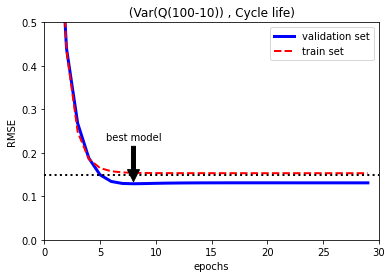

In [90]:
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])
X_train, X_val, y_train, y_val = train_test_split(np.log(X), np.log(Y), test_size=0.2, random_state=10)

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.01,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 30
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse+0.1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
plt.plot([0, n_epochs], [np.sqrt(val_errors[5]), np.sqrt(val_errors[5])], "k:", linewidth=2)
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="train set")
plt.legend(loc="upper right")
plt.axis([0,n_epochs,0,0.5])
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.title(' (Var(Q(100-10)) , Cycle life) ')
plt.show()

다른 예시

In [1]:
# np.random.seed(42)
# m = 100
# X_book = 6 * np.random.rand(m, 1) - 3
# y_book = 2 + X_book + 0.5 * X_book**2 + np.random.randn(m, 1)

# X_train, X_val, y_train, y_val = train_test_split(X_book[:50], y_book[:50].ravel(), test_size=0.5, random_state=10)

# poly_scaler = Pipeline([
#         ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
#         ("std_scaler", StandardScaler()),
#     ])

# X_train_poly_scaled = poly_scaler.fit_transform(X_train)
# X_val_poly_scaled = poly_scaler.transform(X_val)

# sgd_reg = SGDRegressor(max_iter=1,
#                        penalty=None,
#                        eta0=0.0005,
#                        warm_start=True,
#                        learning_rate="constant",
#                        random_state=42)

# n_epochs = 500
# train_errors, val_errors = [], []
# for epoch in range(n_epochs):
#     sgd_reg.fit(X_train_poly_scaled, y_train)
#     y_train_predict = sgd_reg.predict(X_train_poly_scaled)
#     y_val_predict = sgd_reg.predict(X_val_poly_scaled)
#     train_errors.append(mean_squared_error(y_train, y_train_predict))
#     val_errors.append(mean_squared_error(y_val, y_val_predict))

# best_epoch = np.argmin(val_errors)
# best_val_rmse = np.sqrt(val_errors[best_epoch])

# plt.annotate('best model',
#              xy=(best_epoch, best_val_rmse),
#              xytext=(best_epoch, best_val_rmse + 1),
#              ha="center",
#              arrowprops=dict(facecolor='black', shrink=0.05))

# best_val_rmse -= 0.03  # just to make the graph look better
# plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
# plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
# plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="train set")
# plt.legend(loc="upper right")
# plt.xlabel("epochs")
# plt.ylabel("RMSE")
# plt.show()

# Logistic Regression
 로지스틱 회귀는 binary classification 알고리즘 중 하나인 모델이다. 특히 샘플이 특정 클래스에 속할 확률을 추정하는데 사용된다. 
 